In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from datasets import Dataset, ClassLabel
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, TrainingArguments, Trainer, ViTForImageClassification
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

num_classes = 5

# Load the dataset
dataset_torch = datasets.ImageFolder(root='objects', transform=transform)
class_names = dataset_torch.classes

dataset = Dataset.from_dict({
    "pixel_values": [img.numpy() for img, _ in dataset_torch],  # Convert tensors to numpy
    "label": [label for _, label in dataset_torch],
})
dataset = dataset.cast_column(
    "label", 
    ClassLabel(names=class_names)  # Map the class names from torchvision dataset
)

split_datasets = dataset.train_test_split(test_size=0.2)
train_dataset = split_datasets["train"]
test_dataset = split_datasets["test"]

Casting the dataset:   0%|          | 0/176 [00:00<?, ? examples/s]

In [ ]:
!export 

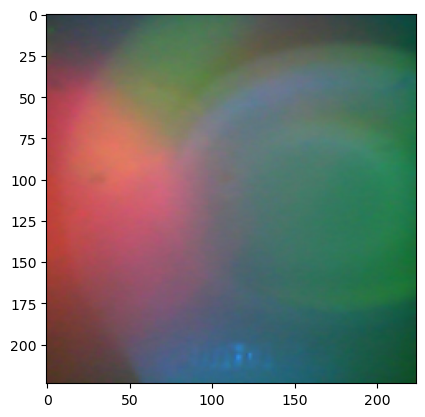

In [4]:
plt.imshow(np.transpose(dataset[0]["pixel_values"], (1, 2, 0)))

In [4]:
# repo_id = "facebook/sparsh-mae-small"
# filename = "mae_vitsmall.safetensors"

# file_path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir="pretrained_models/facebook/sparsh-mae-small")
# print(f"Downloaded file path: {file_path}")

In [5]:
model_name = "google/vit-base-patch16-224-in21k"

In [6]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/home/matthew/miniconda3/envs/tactile_ssl/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

/home/matthew/miniconda3/envs/tactile_ssl/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press c

Abort: 

In [8]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.3968691825866699, 'eval_runtime': 16.7886, 'eval_samples_per_second': 2.144, 'eval_steps_per_second': 0.477, 'epoch': 5.0}


In [9]:
# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Get the predicted class labels (argmax over the logits)
preds = predictions.predictions.argmax(-1)

labels = predictions.label_ids

In [16]:
print("accuracy =", sum(preds == labels)/len(preds))

accuracy = 0.9166666666666666
